
# FMCW

In [28]:

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fft2, fftshift

# range/doppler params
B= 1e9 # bandwidth - Hz
T_chirp = 13e-6 # chirp duration - seconds
Fs = 45e6 # sample rate - Hz
N_chirps = 64 # chirps per frame

# target params
R_true = 25.0 # target range - m
v_true = 11.0 # target velocity - m/s

# angle params
N_RX = 8 # number of Rx
theta_deg = 20.0 # incoming angle
tone_hz = 8e3 # narrowband tone for angle visualization
dur_s = 3e-3 # duration of plot
Fs_view = 300e3 # sample rate for plotted tone - Hz
cursor_t_s = 1.5e-3 # time cursor - s

# Constants
c  = 3e8 # speed
fc = 77e9 # carrier freq
lam = c / fc #wavelength
d_spacing = lam / 2.0
slope = B / T_chirp

range_resolution = c / (2 * B)
max_range = (Fs/2) * c / (2*(B/T_chirp))
velocity_res = lam / (2 * N_chirps * T_chirp)
velocity_max = lam / (4 * T_chirp)

print(f"Range resolution: {range_resolution:.2f} m")
print(f"Max Range: {max_range:.2f} m")
print(f"Max velocity: {velocity_max:.2f} m/s")
print(f"Velocity resolution: {velocity_res:.2f} m/s")


Range resolution: 0.15 m
Max Range: 43.88 m
Max velocity: 74.93 m/s
Velocity resolution: 2.34 m/s


## Range/Doppler

https://www.youtube.com/watch?v=G_tmNtP0gw8&list=PLPQrZqhah1qGvTfkslUUSC1YRa4i1jHTO&index=1

https://colab.research.google.com/drive/1lmYojrI1X7sbctWFrS_61IRUMnzKjAsV#scrollTo=F8qmsmU1ORQA

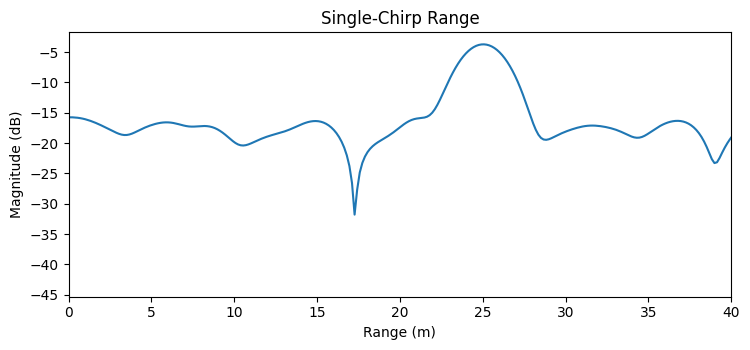

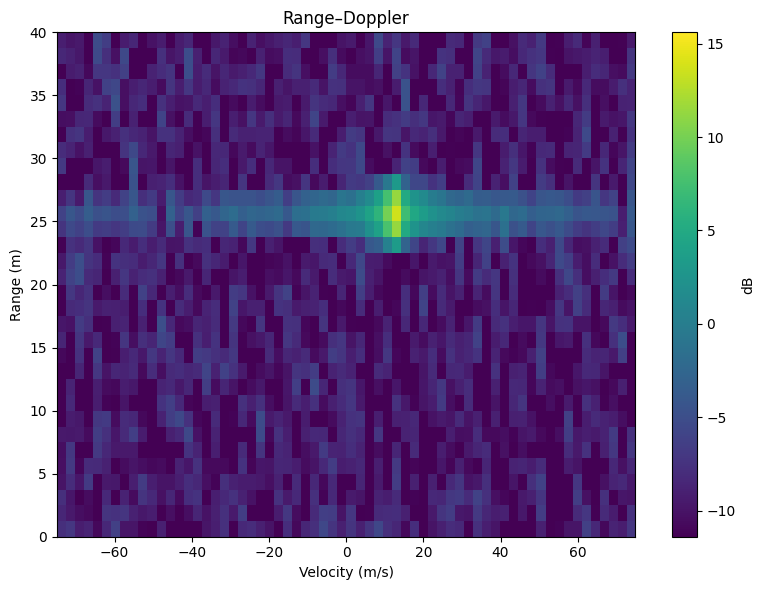

In [29]:
# Derived quantities
f_beat = (2 * R_true * B) / (c * T_chirp) # beat freq
delta_tau= 2 * v_true * T_chirp / c # inter-chirp time shift due to velocity
phase_diff = 2 * np.pi * fc * delta_tau # per-chirp phase increment

# Time grid for one chirp
cycles = 20 # number of beat cycles to show
max_time = cycles / max(f_beat, 1e-6) # seconds
N = 10000 # samples per chirp for plotting/FFT
fs = N / max_time # sampling rate for this synthetic beat
t = np.arange(N) / fs

window = np.blackman(N)

cpi = np.array([
    (np.sin(2*np.pi*f_beat*t + m*phase_diff) + np.random.normal(0, 1.5, N)) * window
    for m in range(N_chirps)
])

# chirp Range FFT
fft_len = N * 8
freq = np.linspace(-fs/2, fs/2, fft_len)

# Range axis mapping
rmax = c * T_chirp * fs / (2 * B) * N/2 / (N/2)
ranges = (c * T_chirp / (2 * B)) * np.linspace(-fs/2, fs/2, fft_len)

Xk = fftshift(fft(cpi[0], fft_len))
Xk = np.abs(Xk) / (N/2)
Xk_db = 10*np.log10(Xk)

plt.figure(figsize=(7.6, 3.6))
plt.plot(ranges, Xk_db)
plt.xlim([0, max(40, 1.1*R_true)])
plt.title("Single-Chirp Range")
plt.xlabel("Range (m)"); plt.ylabel("Magnitude (dB)"); plt.tight_layout(); plt.show()

# Range–Doppler
RD = fftshift(np.abs(fft2(cpi.T))) / (N / 2)

RD_db = 10*np.log10(RD)
ranges_RD = (c * T_chirp / (2 * B)) * np.linspace(-fs/2, fs/2, fft_len)

plt.figure(figsize=(8, 6))
im = plt.imshow(RD_db, aspect='auto', origin='lower',
                extent=[-velocity_max, velocity_max, ranges_RD[0], ranges_RD[-1]],
                vmin=RD_db.max()-25, vmax=RD_db.max()+2)
plt.ylim([0, max(40, 1.2*R_true)])
plt.title("Range–Doppler")
plt.xlabel("Velocity (m/s)"); plt.ylabel("Range (m)")
plt.colorbar(im, label="dB"); plt.tight_layout(); plt.show()

## Angle

https://www.youtube.com/watch?v=GpXF4wVQ-L4

Text(0.5, 1.0, 'Angle FFT')

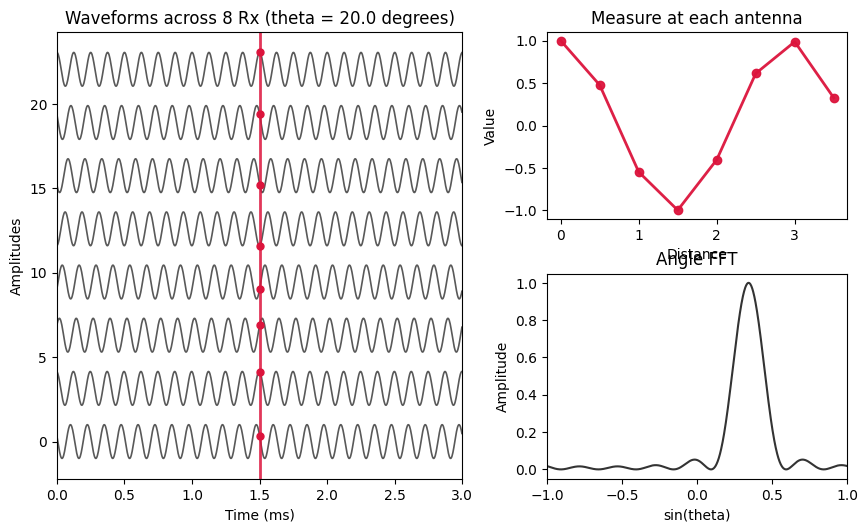

In [30]:
# Build Rx time series
time_view_s = np.arange(int(dur_s * Fs_view)) / Fs_view
phase_step_rad = 2 * np.pi * d_spacing * np.sin(np.deg2rad(theta_deg)) / lam

rx_time_series = np.stack(
    [np.cos(2 * np.pi * tone_hz * time_view_s + m * phase_step_rad) for m in range(N_RX)],
    axis=0
)

# the three panels
fig = plt.figure(figsize=(10.2, 5.8))
grid = fig.add_gridspec(2, 2, height_ratios=[1, 1.1], width_ratios=[1.35, 1], hspace=0.28, wspace=0.24)

# stacked waveforms + cursor + red dots
ax_left = fig.add_subplot(grid[:, 0])
stack_offset = 3.15 * np.max(np.abs(rx_time_series))
for m in range(N_RX):
    ax_left.plot(time_view_s * 1e3, rx_time_series[m] + (N_RX - 1 - m) * stack_offset, color='0.35', lw=1.2)
ax_left.set_title(f"Waveforms across {N_RX} Rx (theta = {theta_deg:.1f} degrees)")
ax_left.set_xlabel("Time (ms)")
ax_left.set_ylabel("Amplitudes")
ax_left.set_xlim([0, 1e3 * dur_s])

# Cursor
ax_left.axvline(cursor_t_s * 1e3, color='crimson', lw=2, alpha=0.85)

# Cursor samples
cursor_idx = int(np.clip(round(cursor_t_s * Fs_view), 0, len(time_view_s) - 1))
snapshot_vals = rx_time_series[:, cursor_idx]
for m in range(N_RX):
    ax_left.plot([cursor_t_s * 1e3], [snapshot_vals[m] + (N_RX - 1 - m) * stack_offset], 'o', color='crimson', ms=5)

# plot amp at each antenna
ax_top_right = fig.add_subplot(grid[0, 1])
element_positions_lambda = (np.arange(N_RX) * d_spacing) / lam
ax_top_right.plot(element_positions_lambda, snapshot_vals, '-o', color='crimson', alpha=0.95, lw=2)
ax_top_right.set_xlabel("Distance")
ax_top_right.set_ylabel("Value")
ax_top_right.set_title("Measure at each antenna")

# Angle FFT
ax_bottom_right = fig.add_subplot(grid[1, 1])

sin_theta_grid = np.linspace(-1.0, 1.0, 1024)
steering_mat = np.exp(1j * 2 * np.pi * (np.arange(N_RX)[:, None]) * (d_spacing / lam) * sin_theta_grid[None, :])

# snapshot of a single plane wave at theta_deg
snapshot_complex = np.exp(1j * np.arange(N_RX) * phase_step_rad)

# power
power_spectrum = np.abs(steering_mat.conj().T @ snapshot_complex) ** 2
power_spectrum /= power_spectrum.max()

ax_bottom_right.plot(sin_theta_grid, power_spectrum, color='0.2', lw=1.5)
ax_bottom_right.set_xlim([-1, 1])
ax_bottom_right.set_xlabel("sin(theta)")
ax_bottom_right.set_ylabel("Amplitude")
ax_bottom_right.set_title("Angle FFT")

## CA-CFAR
https://www.youtube.com/watch?v=BEg29UuZk6c

https://www.mathworks.com/help/phased/ug/constant-false-alarm-rate-cfar-detection.html

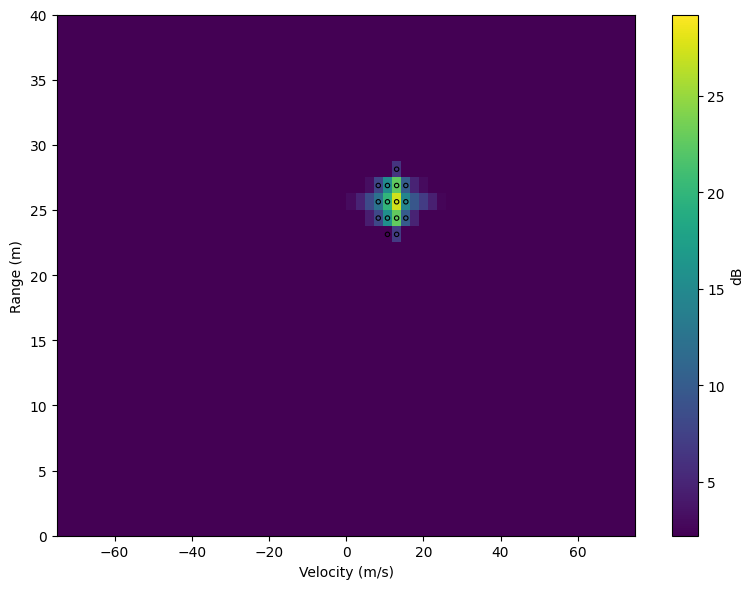

In [ ]:
# Reference and gap cells 
Rr, Gr = 8, 4 # for Range
Rd, Gd = 8, 4 # for Doppler
P_fa = .0001 # bias

def cfar(P, R=8, G=4, P_fa=.0001, axis=0):
    P = P.astype(np.float64, copy=False)
    H = R + G # half the width
    N_reference = R * 2

    # reference + gap + CUT rolling sum
    pad_full = [(0,0), (0,0)]
    pad_full[axis] = (H, H)
    Pf = np.pad(P, pad_full, mode='constant')
    cs_full = np.cumsum(Pf, axis=axis)

    end_windows = [slice(None), slice(None)]
    start_window = [slice(None), slice(None)]
    end_windows[axis] = slice(2*H, 2*H + P.shape[axis])
    start_window[axis] = slice(0, P.shape[axis])
    full_sum = cs_full[tuple(end_windows)] - cs_full[tuple(start_window)]

    # gap + CUT rolling sum
    pad_gap = [(0,0), (0,0)]
    pad_gap[axis] = (G, G)
    Pg = np.pad(P, pad_gap, mode='constant')
    cs_gap = np.cumsum(Pg, axis=axis)

    end_g = [slice(None), slice(None)]
    start_g = [slice(None), slice(None)]
    end_g[axis] = slice(2*G, 2*G + P.shape[axis])
    start_g[axis] = slice(0, P.shape[axis])
    gap_cut_sum = cs_gap[tuple(end_g)] - cs_gap[tuple(start_g)]

    # reference
    reference_sum = full_sum - gap_cut_sum
    noise_mean = reference_sum / float(N_reference)

    # CFAR threshold
    alpha = N_reference * (P_fa ** (-1.0 / N_reference) - 1.0)
    threshold = alpha * noise_mean

    # Valid region is where a full window exists
    valid = np.zeros_like(P, dtype=bool)
    if axis == 0: # range
        valid[H:P.shape[0]-H, :] = True
    else: # doppler
        valid[:, H:P.shape[1]-H] = True

    detections = (P > threshold) & valid
    return detections

# run 2 passes on power
RD_power = (RD ** 2).astype(np.float64)

detection_r = cfar(RD_power, R=Rr, G=Gr, P_fa=P_fa, axis=0)
detection_d = cfar(RD_power, R=Rd, G=Gd, P_fa=P_fa, axis=1)

detections_1d_and = detection_r & detection_d

# Visualize
vel_axis = np.linspace(-velocity_max, velocity_max, RD.shape[1])
range_axis = (c * T_chirp / (2 * B)) * np.linspace(-fs/2, fs/2, RD.shape[0])

rr, vv = np.where(detections_1d_and)
plt.figure(figsize=(8, 6))
im = plt.imshow(10*np.log10(RD_power + 1e-12), aspect='auto', origin='lower',
                extent=[vel_axis[0], vel_axis[-1], range_axis[0], range_axis[-1]],
                vmin=np.nanmax(10*np.log10(RD_power+1e-12))-25,
                vmax=np.nanmax(10*np.log10(RD_power+1e-12))+2)
plt.scatter(vel_axis[vv], range_axis[rr], s=10, facecolors='none', edgecolors='k', linewidths=0.8)
plt.ylim([0, max(40, 1.2*R_true)])
plt.xlabel("Velocity (m/s)"); plt.ylabel("Range (m)")
plt.colorbar(im, label="dB")
plt.tight_layout(); plt.show()
